# Analisi del risultato job 2 MR, HIVE e SPARK


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np



## metodi util

In [2]:
#funzione per la creazione di un dizionario #value->count
def create_dic_value_count_MR(lines):
    out={}
    for line in lines:
        line=line.strip()
        elements=line.split('\t')
        if len(elements)>1:
            key_val=elements[1]
            if key_val not in out:
                out[key_val]=0
            out[key_val]+=1
    return out

        

In [3]:
#filtraggio della mappa prendendo inc onsiderazione solamente i valori maggiori di k
def create_dic_value_count_filter_k(input,k):
    out={}
    for i in input.keys():
        if input[i]>=k:
            out[i]=input[i]
    return out


In [4]:
#funzione per la lettura dell'input (output del job mr)
def read_input_MR(path):
    lines=''
    with open(path,'r') as f:
        lines=f.readlines()
    return lines

In [5]:
def read_input_HIVE(path):
    data=pd.read_csv(path)
    return data

In [6]:
#Creazione e plot CDF
#input->dizionario
def plot_CDF(input,title,save_path):
    keys=np.array(list(input.keys()))
    values=np.array(list(input.values()))

    #sort dell'array in ascending order
    sort_idx=np.argsort(keys)
    keys=keys[sort_idx]
    values=values[sort_idx]
    

    #fattore di normalizzazione
    N=np.cumsum(values)

    #normalizzazione
    cdf=N/N[-1]
    plt.plot(keys, cdf)
    plt.xlabel('Values')
    plt.ylabel('Cumulative Probability')
    plt.title(title)
    fig1=plt.gcf()
    fig1.savefig(save_path)
    plt.show()
   



In [7]:
def prep_data(data):
    keys=np.array(list(data.keys()))
    values=np.array(list(data.values()))

    #sort dell'array in ascending order
    sort_idx=np.argsort(keys)
    keys=keys[sort_idx]
    values=values[sort_idx]
    

    #fattore di normalizzazione
    N=np.cumsum(values)

    #normalizzazione
    cdf=N/N[-1]
    return cdf,keys

In [8]:
#CLF comunlativo dei risultati HIVE, SPARK, MR
def plot_cum_CLF(data,title,path):
    colors=['red','green','blue','yellow']
    labels=['MR','Hive','SPARK','SPARK-SQL']

    i=0
    for i in range(len(data)):
        current_data=data[i]
        cdf,keys=prep_data(current_data)
        plt.plot(keys,cdf,color=colors[i],label=labels[i])
    
    plt.legend()
    plt.title(title)
    plt.savefig(path)
    plt.show()
        
    


In [9]:
#plot della distribuzione
def plot_distribution(input):
    
    keys=list(input.keys())
    values = np.array(list(input.values()))/len(input)
    # Create a histogram of the values

    # Plot the histogram
    plt.bar(keys,values)
    plt.xlabel('Values')
    plt.ylabel('Frequency')
    plt.title('Distribution of Dictionary Elements')
    plt.show()

## ANALISI OUTPUT MR

In [10]:
#MR analysis
PATH_INPUT=r"../MR/output2/output.txt"

lines=read_input_MR(PATH_INPUT)

map_value_count=create_dic_value_count_MR(lines)

min_value_count=min(map_value_count.values())
max_value_count=max(map_value_count.values())

mean_value_count=sum(map_value_count.values())/len(map_value_count.keys())

map_value_count_filter=create_dic_value_count_filter_k(map_value_count,mean_value_count)

print("Min value:",min_value_count)
print("Max value:",max_value_count)
print("AVG value:",mean_value_count)

#print(map_value_count)


Min value: 1
Max value: 119810
AVG value: 40.92360556177081


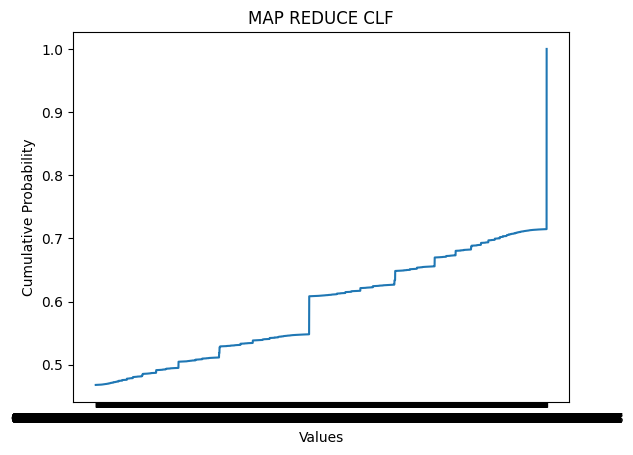

In [11]:
plot_CDF(map_value_count,title="MAP REDUCE CLF", save_path="CLF_MR.jpg")

## Analisi risultati HIVE

In [12]:
LOCAL_HIVE_OUT_PATH="../HIVE/output/output.csv"
data=read_input_HIVE(LOCAL_HIVE_OUT_PATH)
data.head(10)




,UserId,Score
0,A1T3LA8JBH1EAV,1.0
1,A1T3J0ORTNOBOW,1.0
2,A1CPWKVHEWSIO3,1.0
3,A1CQ51299RSL79,1.0
4,A1T3BH8PLV8W8W,1.0
5,A1T3ABYJNZZN7C,1.0
6,A1CQBR8TNDCN4T,1.0
7,A1CQJ11ZE07MYC,1.0
8,ATNLUAQ32L6ZR,1.0
9,A1T345VG0EX9T0,1.0


In [13]:
score2count=data['Score'].value_counts()

score2count=score2count.to_dict()


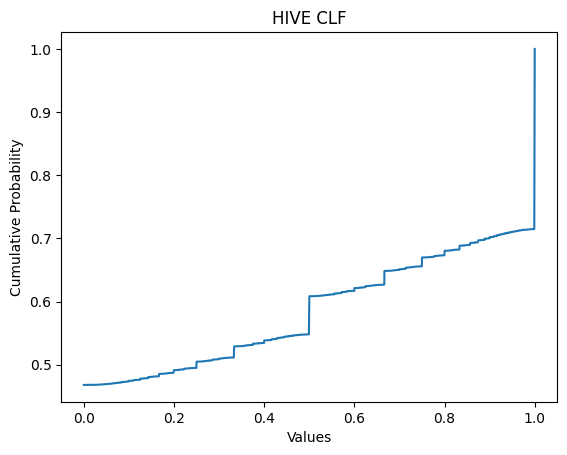

In [14]:
#Conversione in una mappa per la stampa del CLF
plot_CDF(score2count,title='HIVE CLF',save_path="Hive_CLF.jpg")


## Confronto HIVE vs MR

### Confrotno CLF HIVE, MR

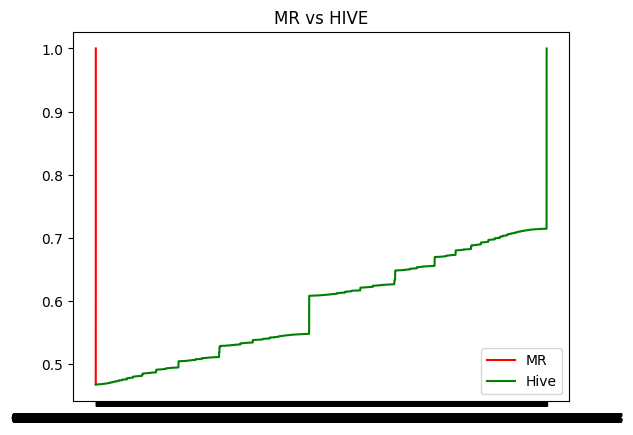

In [16]:
plot_cum_CLF(data=[score2count,map_value_count],title='MR vs HIVE',path="MP_vs_HIVE.jpg")

### Confronto Valori HIVE vs MR


In [18]:
def convert_data(lines):
    columns=['UserId','Score']
    out=[]
    for line in lines:
        entry=[]
        line=line.strip()
        values=line.split('\t')
        if len(values)==2:
            user_id=values[0]
            score=values[1]
            entry=[user_id,score]
            out.append(entry)
    
    return pd.DataFrame(data=out,columns=columns)
    

In [53]:
Hive_Data=pd.read_csv('../HIVE/output/output.csv')

MR_data=read_input_MR('../MR/output2/output.txt')
MR_data=convert_data(MR_data)




In [54]:
#join dei dataframe
merge_data=pd.merge(MR_data,Hive_Data,'outer',on='UserId')
merge_data['Score_x']=merge_data['Score_x'].astype(float).round(4)
merge_data['Score_y']=merge_data['Score_y'].astype(float).round(4)
merge_data.head(10)

,UserId,Score_x,Score_y
0,#oc-R163CP16SRRI50,1.0,1.0
1,#oc-R19QDOY2PXS15,1.0,1.0
2,#oc-R1B9W981WGB5D0,1.0,1.0
3,#oc-R1I879FCTH83GM,1.0,1.0
4,#oc-R1KIN7Z6UZUU8Q,1.0,1.0
5,#oc-R1OGEG6X7R7642,1.0,1.0
6,#oc-R1P45E92XO67UX,1.0,1.0
7,#oc-R1UHB5HAUGHE85,1.0,1.0
8,#oc-R1XE00JQIJIPUH,1.0,1.0
9,#oc-R1XK2SYVVK4FZA,1.0,1.0


In [55]:
#Check errors
error=merge_data[merge_data['Score_x']!=merge_data['Score_y']]
error.to_csv('error_MR_Hive.csv',index=False)


,UserId,Score_x,Score_y
100018,A2M9D9BDHONV3Y,0.5293,0.5292
116964,A18TST0YO1NN2,0.4437,0.4438
117723,A100UZGZNZ9ZYN,0.4187,0.4188


,UserId,Score
146641,UserId,0.0
